In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 241.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 1.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 208.4 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [4]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [5]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [6]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [7]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=25)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [8]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    r0=df_tmp.iloc[-1].Price
    r1= ( df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.05) ) 
    r2=float(df_tmp_2["Bol_Up_30"].values) 
    df_tmp_2["%change"]=((r2-r0)/ abs(r0) ) *100
    #print(r1)
    #print(r2)
    if r1<=r2:
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
#display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
MA

In [9]:
display(df_buy_signal) 

""


In [10]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [11]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

In [12]:
display(df_buy_signal)

""


In [13]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


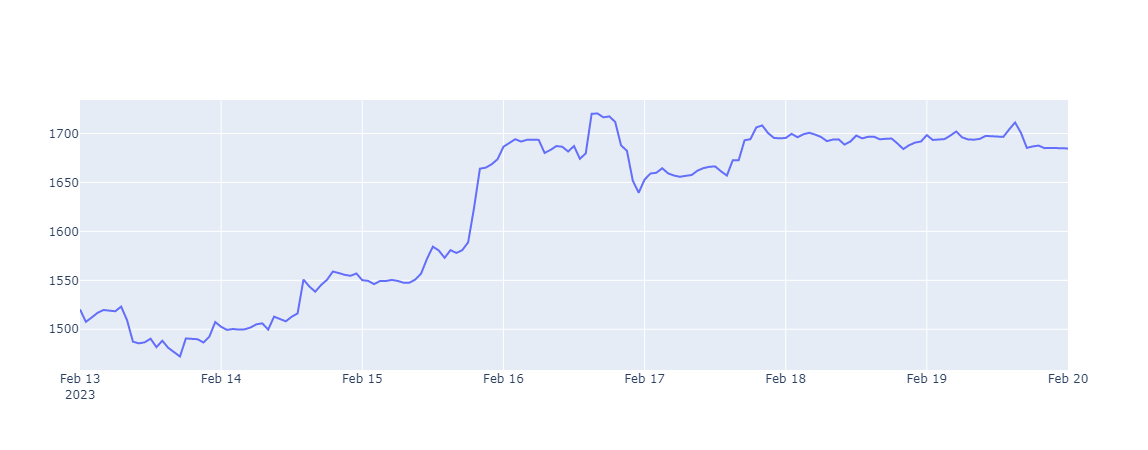

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


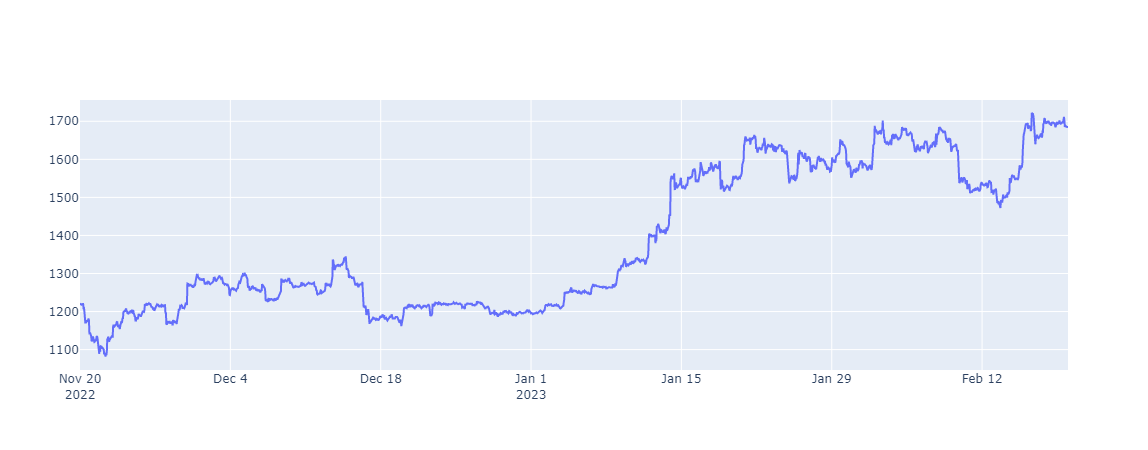

In [14]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [15]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,5233.6304,113.8999,153.8645,-36.5297,45.8113,15.7577,11.6090,0.0
1,ETH-USD,425.0917,88.1829,553.2036,-35.9011,37.9737,8.7587,10.8270,0.0
2,BNB-USD,15590.1499,3053.6623,1305.1587,-17.9796,14.5582,6.2907,-0.1329,0.0
3,XRP-USD,78.2080,-64.4245,42.2859,-50.2013,-0.3786,-0.8100,2.7047,0.0
4,ADA-USD,1153.2524,6.0526,589.5039,-56.9403,21.8673,19.0043,10.1461,0.0
5,BUSD-USD,-0.1171,-0.1171,0.0154,0.1440,-0.0593,0.0101,0.0334,0.0
6,MATIC-USD,33602.4655,33602.4655,7099.3912,-1.7062,69.8594,56.8197,20.3921,0.0
7,DOGE-USD,6069.8940,1130.6738,3183.3396,-36.2130,3.1865,7.2466,5.9554,0.0


In [16]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-02-10,BTC-USD,21651.183594,24019.992231,21329.017814,537.979719,904.117184,Sell
2023-02-11,BTC-USD,21870.875,23788.495279,21143.094007,436.021017,810.497951,Sell
2023-02-12,BTC-USD,21788.203125,23627.861304,20970.167156,344.575036,717.313368,Sell
2023-02-13,BTC-USD,21808.101562,23466.256301,20859.769927,270.589882,627.968671,Sell
2023-02-14,BTC-USD,22220.804688,22901.877231,21126.010046,242.462847,550.867506,Sell
2023-02-15,BTC-USD,24307.841797,24092.805164,20326.06593,384.150178,517.52404,Sell
2023-02-20,BTC-USD,24392.505859,25024.916761,20129.230561,497.534819,513.526196,Sell
2023-02-10,ETH-USD,1514.869141,1735.892794,1492.387165,32.079162,53.285247,Sell
2023-02-11,ETH-USD,1539.926758,1718.816384,1473.14002,24.733788,47.574955,Sell


In [17]:
from datetime import timedelta
df_ALGO = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_ALGO.index[-1]+ timedelta(days=1)

print(df_ALGO)

df_ALGO.loc[date, :] = [0]


print(df_ALGO.size)

df_ALGO['S1'] = df_ALGO['Close'].shift(1)
df_ALGO['SMA3'] = df_ALGO['Close'].rolling(3).mean().shift(1)
df_ALGO['SMA5'] = df_ALGO['Close'].rolling(5).mean().shift(1)
df_ALGO['SMA15'] = df_ALGO['Close'].rolling(15).mean().shift(1)
df_ALGO['SMA30'] = df_ALGO['Close'].rolling(30).mean().shift(1)

df_ALGO['S1'] = df_ALGO['S1'].fillna(0)
df_ALGO['SMA3'] = df_ALGO['SMA3'].fillna(0)
df_ALGO['SMA5'] = df_ALGO['SMA5'].fillna(0)
df_ALGO['SMA15'] = df_ALGO['SMA15'].fillna(0)
df_ALGO['SMA30'] = df_ALGO['SMA30'].fillna(0)



X = df_ALGO.iloc[:, 1:-1].values
y = df_ALGO.iloc[:, 0].values



df_ALGO

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
               Close
Date                
2019-06-21  3.201412
2019-06-22  2.158967
2019-06-23  1.890702
2019-06-24  1.383728
2019-06-25  1.537290
...              ...
2023-02-12  0.248337
2023-02-13  0.244658
2023-02-14  0.253670
2023-02-15  0.272708
2023-02-20  0.279731

[1337 rows x 1 columns]
1338


,Close,S1,SMA3,SMA5,SMA15,SMA30
Date,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.417027,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.811132,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2023-02-13,0.244658,0.248337,0.252512,0.260571,0.258873,0.248686
2023-02-14,0.253670,0.244658,0.250061,0.251500,0.257704,0.249190
2023-02-15,0.272708,0.253670,0.248888,0.251173,0.258631,0.249635


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)


ann=tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=12,
                              activation="relu"))

ann.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
ann.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])

# Fitting the ANN to the Training set
ann.fit(X_train, y_train ,batch_size = 50, epochs = 100)



2023-02-20 00:12:38.553262: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-20 00:12:38.680056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
25/25 [==============================] - 1s 1ms/step - loss: 0.5844 - mse: 0.5844
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 0.4219 - mse: 0.4219
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 0.2576 - mse: 0.2576
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1227 - mse: 0.1227
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0521 - mse: 0.0521
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0364 - mse: 0.0364
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0340 - mse: 0.0340
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0321 - mse: 0.0321
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0301 - mse: 0.0301
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0281 - mse: 0.0281
Epoch 11/100
25/25 [==============================] - 0s 1m

In [19]:
y_test[:-1]

array([0.341346  , 0.33428901, 0.338705  , 0.32015499, 0.317395  ,
       0.31430599, 0.31931499, 0.31733701, 0.31928501, 0.32267201,
       0.33011401, 0.31950101, 0.307179  , 0.30699301, 0.312841  ,
       0.31345099, 0.315698  , 0.31445   , 0.331707  , 0.339315  ,
       0.32674801, 0.33378699, 0.33867699, 0.35925701, 0.359101  ,
       0.36001799, 0.36157301, 0.36922199, 0.41486999, 0.42339   ,
       0.404138  , 0.41834399, 0.33228999, 0.26510599, 0.31977201,
       0.302286  , 0.27337599, 0.26217699, 0.260948  , 0.28126699,
       0.27616799, 0.26797599, 0.29757699, 0.298621  , 0.25611299,
       0.245101  , 0.24059901, 0.246718  , 0.24211399, 0.2436    ,
       0.240537  , 0.240466  , 0.235966  , 0.240555  , 0.2483    ,
       0.240749  , 0.244508  , 0.23791599, 0.24011201, 0.236687  ,
       0.23409399, 0.22157   , 0.224718  , 0.22571699, 0.227487  ,
       0.223087  , 0.21865401, 0.223529  , 0.220916  , 0.210502  ,
       0.185554  , 0.19459599, 0.188841  , 0.17417499, 0.17897

In [20]:
import sklearn.metrics

predictions = ann.predict(X_test)
mse_no=sklearn.metrics.mean_squared_error(y_test[:-1],predictions[:-1])

print(mse_no)

print(y_test[-7:])
print(predictions[-7:])



0.00042419105199276245
[0.25718901 0.248337   0.24465799 0.25367001 0.272708   0.27973136
 0.        ]
[[0.26361343]
 [0.26193318]
 [0.2556239 ]
 [0.25276607]
 [0.2579817 ]
 [0.27350715]
 [0.2829501 ]]


In [21]:
type( y_test[-7:] )

print(y_test[-7:].shape)
print(predictions[-7:].shape)

z=y_test[-7:].reshape(7,1)

print(z.shape)

final=np.hstack((z,predictions[-7:] ))

final

(7,)
(7, 1)
(7, 1)


array([[0.25718901, 0.26361343],
       [0.248337  , 0.26193318],
       [0.24465799, 0.25562391],
       [0.25367001, 0.25276607],
       [0.272708  , 0.25798169],
       [0.27973136, 0.27350715],
       [0.        , 0.2829501 ]])

In [22]:
from datetime import datetime
# create an index list object
timestamp_list = pd.date_range(df_ALGO.index[-7], periods=7).tolist()

# create new dataframe
x1=pd.DataFrame(final, columns=["real","predict"],index=timestamp_list)
x1['diff'] = x1['real'] - (x1['predict'])
x1

,real,predict,diff
2023-02-11,0.257189,0.263613,-0.006424
2023-02-12,0.248337,0.261933,-0.013596
2023-02-13,0.244658,0.255624,-0.010966
2023-02-14,0.253670,0.252766,0.000904
2023-02-15,0.272708,0.257982,0.014726
2023-02-16,0.279731,0.273507,0.006224
2023-02-17,0.000000,0.282950,-0.282950


In [39]:
df_alg = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_alg.index[-1]+ timedelta(days=1)
df_alg.loc[date, :] = [0]

for i in range (1,61):
    a="Close_"+str(i)
    #print(a)
    df_alg[a]=df_alg['Close'].shift(i)

df_alg=df_alg.fillna(0)
display(df_alg)

X = df_alg.iloc[:, 1:].values
y = df_alg.iloc[:, 0].values

def calc_LTSM( p_units ,p_epoch ,p_batch_size ):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)
    # Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Importing the Keras libraries and packages
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    regressor = Sequential()
    
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = p_epoch, batch_size = p_batch_size)
    
    lastElementIndex = len(X_test)-1
    # Removing the last element using slicing 
    X_pre = X_test[:lastElementIndex]
    y_pre = y_test[:lastElementIndex]
    X_pre = np.array(X_pre)
    X_pre = np.reshape(X_pre, (X_pre.shape[0], X_pre.shape[1], 1))
    predicted_stock_price = regressor.predict(X_pre)
    #print("*****")
    #print(predicted_stock_price)
    
    index1 = len(X_test)-1
    index2 = len(X_test)
    X_final = X_test[index1:index2]
    y_final = y_test[index1:index2]
    X_final = np.array(X_final)
    X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], 1))
    
    print(y_final)
    print("Params: "+str(p_units)+" "+str(p_epoch)+" "+str(p_batch_size) )
    predicted_stock_price = regressor.predict(X_final)
    print(predicted_stock_price)

calc_LTSM(100,5,150)
calc_LTSM(100,100,150)

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_51,Close_52,Close_53,Close_54,Close_55,Close_56,Close_57,Close_58,Close_59,Close_60
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,0.244658,0.248337,0.257189,0.252010,0.255304,0.290014,0.279158,0.255421,0.257102,0.267021,...,0.168379,0.170122,0.171767,0.171881,0.178975,0.174175,0.188841,0.194596,0.185554,0.210502
2023-02-14,0.253670,0.244658,0.248337,0.257189,0.252010,0.255304,0.290014,0.279158,0.255421,0.257102,...,0.165872,0.168379,0.170122,0.171767,0.171881,0.178975,0.174175,0.188841,0.194596,0.185554
2023-02-15,0.272708,0.253670,0.244658,0.248337,0.257189,0.252010,0.255304,0.290014,0.279158,0.255421,...,0.171503,0.165872,0.168379,0.170122,0.171767,0.171881,0.178975,0.174175,0.188841,0.194596


Epoch 1/5
9/9 [==============================] - 12s 442ms/step - loss: 0.2949
Epoch 2/5
9/9 [==============================] - 4s 453ms/step - loss: 0.1391
Epoch 3/5
9/9 [==============================] - 5s 543ms/step - loss: 0.1380
Epoch 4/5
9/9 [==============================] - 4s 455ms/step - loss: 0.1186
Epoch 5/5
9/9 [==============================] - 4s 451ms/step - loss: 0.1080
[0.]
Params: 100 5 150
[[0.33658546]]
Epoch 1/100
9/9 [==============================] - 13s 470ms/step - loss: 0.2882
Epoch 2/100
9/9 [==============================] - 4s 479ms/step - loss: 0.1658
Epoch 3/100
9/9 [==============================] - 5s 546ms/step - loss: 0.1443
Epoch 4/100
9/9 [==============================] - 4s 460ms/step - loss: 0.1279
Epoch 5/100
9/9 [==============================] - 4s 446ms/step - loss: 0.1231
Epoch 6/100
9/9 [==============================] - 4s 444ms/step - loss: 0.1002
Epoch 7/100
9/9 [==============================] - 4s 458ms/step - loss: 0.0781
Epoch 8/10

In [ ]:
#LTSM RNN

df_alg = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))

date=df_alg.index[-1]+ timedelta(days=1)

df_alg.loc[date, :] = [0]

for i in range (1,61):
    a="Close_"+str(i)
    #print(a)
    df_alg[a]=df_alg['Close'].shift(i)



df_alg=df_alg.fillna(0)

display(df_alg)


# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

X = df_alg.iloc[:, 1:].values
y = df_alg.iloc[:, 0].values


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)
#display(X_train)
#display(X_test)
#X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


display(X_train)

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 150)





In [ ]:
index1 = len(X_test)-1
index2 = len(X_test)
X_final = X_test[index1:index2]
y_final = y_test[index1:index2]



In [ ]:
lastElementIndex = len(X_test)-1
# Removing the last element using slicing 
X_pre = X_test[:lastElementIndex]
y_pre = y_test[:lastElementIndex]


In [ ]:
X_pre = np.array(X_pre)
X_pre = np.reshape(X_pre, (X_pre.shape[0], X_pre.shape[1], 1))


predicted_stock_price = regressor.predict(X_pre)
print("*****")
print(predicted_stock_price)

In [ ]:
X_final = np.array(X_final)
X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], 1))


predicted_stock_price = regressor.predict(X_final)
print("*****")
print(y_final)
print(predicted_stock_price)

In [ ]:
#****---------------------------------------------------------------------------------------------------------------------------

In [ ]:
index1 = len(X_test)-1
index2 = len(X_test)
#X_final = X_test[:index1:index2]
#y_final = y_test[:index1:index2]

#0.354747

print( y_test[index1:index2]   )

print(type(y_test))

df_alg.iloc[0:4,0:2]

print(df_alg.tail(1))

In [ ]:
from datetime import timedelta


dfe0=getRates('ETH-USD',  '10y',  '1d')


display(type(dfe0))


display(dfe0)

date=dfe0.index[0]+ timedelta(days=-1)
s1 = pd.Series([0],index=[date])

dfe1=s1.append(dfe0)

display(dfe1)
